# FSM Environment Exceptions
These classes throw exceptions in case of internal data errors in the CSV file during the operation of the custom gym environment.

In [1]:
class FSMFileTransitionsError(Exception):
    """
    This exception ensures that the FSM loaded from the CSV file has a correct amount of transitions.
    """  
    def __init__(self, list_of_states):
        print("ERROR: States of the following unique IDs have at least one of the following errors:")
        print("1. The amount of states in the 'Transitions_to_states' field is not equal to the amount of actions in the 'Possible_discrete_actions_(transitions)' field.")
        print("2. The amount of states in the 'Transitions_to_states' field is not equal to the amount of transitions in the 'Transition_names' field.")
        print("3. The amount of actions in the 'Possible_discrete_actions_(transitions)' field is not equal to the amount of transitions in the 'Transition_names' field.")
        print(*list_of_states)
        print("Please recheck the states and try again.")

In [2]:
class FSMStartStateNotFoundError(Exception):
    """
    This exception ensures that the FSM loaded from the CSV file has any start states in case a preset one has not been provided.
    """
    def __init__(self):
        print("ERROR: No start states have been found in the CSV file!")
        print("Please recheck the file and set at least a single start state.")

In [3]:
class FSMTransitionStateNotFoundError(Exception):
    """
    This exception is thrown in case the CSV file does not contain a state that the environment was meant to transition to.
    """
    def __init__(self, unique_id):
        print("ERROR: The transition to a state of the unique ID: {} has failed due to the state not being found in the CSV file!".format(unique_id))
        print("If this was not expected, please check the CSV file.")

In [4]:
class FSMIncorrectPresetStartStateError(Exception):
    """
    This exception ensures that a correct preset state has been provided (or if it actually exists in the CSV file).
    """
    def __init__(self, unique_id):
        print("ERROR: The provided preset start state of the unique ID {} has not been found in the CSV file, or is not set as a start state.".format(unique_id))
        print("Please change the preset ID or set the state to be a start state in the CSV file.")

# Helper functions for pre-eliminary testing of the loaded CSV file
The following functions and exception help to prepare the CSV file for later use. However, they serve more as helpers rather than Q&A bug-testing methods, since they will not detect a CSV file broken beyond anything of quick repair, for example when there are mistyped types (i.e. the row 'Unique_ID' having a value of "UniqueID#01" instead of 1).

In [5]:
import pandas

def convert_state_names(file_name:str) -> None:
    """
    This function adds discretized state names in case the CSV file provided does not contain such a column.
    
    Example: On -> 1, Off -> 2, Reset -> 3, On -> 1 

    Warning: Although Pandas will by default load the CSV file in chunks to help with large file sizes, it might still crash when used on files of excessive file size (above available memory size).
    
    :param file_name: The file name of the CSV file.
    """
    df = pandas.read_csv(file_name, low_memory=True, memory_map=True)

    if 'Discretized_state_name' not in df.columns:
        state_names_dict = {}
        counter = 1
        # We use itertuples here as it is the fastest way of iterating row by row in a Pandas dataframe.
        for row in df.itertuples(index=False):
            # print(row)
            if row.State_name not in state_names_dict:
                state_names_dict[row.State_name] = counter
                # print(state_names_dict[row.State_name])
                counter += 1
        
        df['Discretized_state_name'] = df['State_name'].map(state_names_dict)
        df.to_csv(file_name, index=False)
        print('SUCCESS: Discretized state names have been added to the provided CSV file.')

    else:
        print('INFO: The CSV file provided already contains discretized state names.')

In [6]:
# Uncomment the following line to test the function for yourself:
# convert_state_names('csv_files/pelican_without_dsn.csv')
convert_state_names('csv_files/pelican.csv')

INFO: The CSV file provided already contains discretized state names.


In [7]:
class CSVEmptyValues(Exception):
    """
    This exception is thrown in case it contains empty values in at least one row.
    """
    def __init__(self, list_of_rows):
        print("ERROR: The following rows of the CSV file provided contain empty values:")
        print(*list_of_rows)
        print("Please recheck the CSV file.")

In [8]:
from csv import DictReader

def is_csv_empty(file_name:str) -> None:
    """
    This function checks if any value in each row is empty.
    
    :param file_name: The file name of the CSV file.
    """
    with open(file_name, 'r') as csv_file:
        # DictReader allows us to read each row of the CSV file as an ordered dictionary
        csv_dict_reader = DictReader(csv_file)
        empty_rows = []

        # Iterate over each row
        for count, row in enumerate(csv_dict_reader, start=2):
            for value in row.values():
                if not value:
                    # If a value is empty in a given row, append the index of it
                    empty_rows.append(count)
                    break
        
        if not empty_rows:
            print("INFO: The CSV file provided does not contain any empty values in its columns.")

        else:
            raise CSVEmptyValues(empty_rows)

In [9]:
# Uncomment the following line to cause the exception to happen
# is_csv_empty('csv_files/blank.csv')
is_csv_empty('csv_files/pelican.csv')

INFO: The CSV file provided does not contain any empty values in its columns.


# Custom gym environment - FSMEnv

In [10]:
import numpy as np
import gym
import random
from csv import DictReader

class FSMEnv(gym.Env):
  """
  Custom environment that follows the OpenAI Gym interface.
  
  In this environment, an agent begins at a start state in a finite state machine and, by using provided transitions as its action space (which may vary), tries to learn the longest path from it without looping back to any previously visited state. 
  
  All observations are directly provided from a CSV file, but as the CSV file might not fit into memory, any operations related to the file I/O are proceeded by traversing through the CSV file row by row. 
  """

  def __init__(self, file_name:str, start_state_id:int=None):
    """
    :param file_name: The file name of the CSV file.
    :param start_state_id: Allows to set a preset start state. If given a value of 0, the environment will randomize the chosen start state at each reset of the environment.
    """
    super(FSMEnv, self).__init__()

    self.file_name = file_name
    self.start_state_id = start_state_id
    self.randomize_start_state = False
    self.start_states = []
    self.start_state_has_been_set = False

    # When using a wrapper for vectorized environments, as we are "stepping" over, 
    # the environments in the venv reset automatically by themselves when an episode ends.

    # This means we are not able to access the observation of an agent
    # when the episode is already marked as "done", since the venv
    # skips over right to the beginning of the episode.
    
    # The variable below therefore allows us to access the node that has been visited
    # right before the reset in the rendering wrapper.
    self.last_node_before_reset = None
    preset_start_state = False

    # We use the helper functions here to test the CSV file and essentially 
    # crash the initialization of the environment in case the CSV file is broken.
    convert_state_names(file_name)
    is_csv_empty(file_name)

    # If no preset start state has been declared,
    # the function will try to find such in the CSV file.
    if start_state_id is None:
      preset_start_state = False

    # If the start state parameter has been set to 0,
    # the function will try to find start states in the CSV file
    # and randomize between them when resetting the environment.
    elif int(start_state_id) == 0:
      # While we have "preset" a start state (of 0), we set the boolean here to false
      # to minimize the duplication of code in order to 
      # allow the function to append start states later on.
      preset_start_state = False
      self.randomize_start_state = True

    # If a preset start state has been declared,
    # the function will try to find in the CSV file.
    else:
      preset_start_state = True
      self.start_state_id = int(start_state_id)

      with open(self.file_name, 'r') as csv_file:
        correct_preset_start_state = False
        # DictReader allows us to read each row of the CSV file as an ordered dictionary
        csv_dict_reader = DictReader(csv_file)

        # Iterate over each row. The row variable is a dict, representing a row in the CSV file
        for row in csv_dict_reader:
          if int(row['Unique_ID']) == self.start_state_id:
            # If the row has been found, and is a start state, everything is correct.
            if row['Start_state'] == '1':
              correct_preset_start_state = True
              self.start_state_has_been_set = True
        
        # If not, we raise an exception here
        if correct_preset_start_state == False:
          raise FSMIncorrectPresetStartStateError(self.start_state_id)

    # The function will proceed to this if statement if a preset start state has been not provided,
    # trying to find any start states in the CSV file.
    if preset_start_state == False:
      any_start_state_found = False
      multiple_start_states = False

      with open(self.file_name, 'r') as csv_file:
        # DictReader allows us to read each row of the CSV file as an ordered dictionary
        csv_dict_reader = DictReader(csv_file)

        # Iterate over each row. The row variable is a dict, representing a row in the CSV file
        for row in csv_dict_reader:
          # Append each start state to a list in case the user decides 
          # further on to randomize the start state at each reset of the environment
          if row['Start_state'] == '1':
            self.start_states.append(int(row['Unique_ID']))
            
            if self.start_state_has_been_set == False:
              # This boolean serves as a check to ensure there is
              # at least one start state in the CSV file.
              any_start_state_found = True
              self.start_state_has_been_set = True
              # In case there is only one start state, we set it as the default one.
              self.start_state_id = int(row['Unique_ID'])

            elif multiple_start_states == False:
              self.start_state_id = None
              multiple_start_states = True
      
        # If the user has not defined a preset start state or set the environment to
        # randomize the start state each time, and multiple start states have been found,
        # the function will ask the user to provide a start state to reset to each time, 
        # or if to set to randomize the start state.
        if multiple_start_states == True and self.randomize_start_state == False:
          print("Multiple start states have been found!")
          correct_start_state_provided = False

          while correct_start_state_provided == False:
            print("Please choose one of the found start states:")
            for unique_id in self.start_states:
              print(unique_id)
              
            print("Or input 0 to randomize the start state at each reset of the environment.")

            self.start_state_id = int(input("Provide an unique ID: "))
            
            if self.start_state_id not in self.start_states:
              # If the user provided a value of 0, the env will randomize the start states.
              if self.start_state_id == 0:
                self.start_state_has_been_set = False
                self.randomize_start_state = True
                correct_start_state_provided = True
              else:
                print("ID provided is not in the list!")
            
            else:
              # If the user has provided a single start state, we empty the start_state list 
              # for memory conservation as we do not need to store them anymore.
              self.start_states = []
              correct_start_state_provided = True
              self.start_state_has_been_set = True

      # If there have been not start states found, an exception is thrown
      if any_start_state_found == False:
        raise FSMStartStateNotFoundError()
        
    if self.randomize_start_state == True:
      # Randomize a start state in case the user forgets to reset the env
      self.start_state_id = random.choice(self.start_states)

    self.row_counter = 0

    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions, we have two: left and right
    with open(self.file_name, 'r') as csv_file:
      csv_dict_reader = DictReader(csv_file)
      broken_states = []
      broken_states_exist = False

      for row in csv_dict_reader:
        self.row_counter += 1

        if len(row['Transitions_to_states'].split()) != int(row['Possible_discrete_actions_(transitions)']) or len(row['Transitions_to_states'].split()) != len(row['Transition_names'].split()) or int(row['Possible_discrete_actions_(transitions)']) != len(row['Transition_names'].split()):
          if broken_states_exist == False:
            broken_states_exist = True
          broken_states.append(row['Unique_ID'])

        if int(row['Unique_ID']) == self.start_state_id:
          initial_actions = int(row['Possible_discrete_actions_(transitions)'])
          self.action_space = gym.spaces.Discrete(initial_actions)
          self.transitions_to_states = np.array(row['Transitions_to_states'].split(), dtype=np.int64)
    
    if broken_states_exist == True:
      raise FSMFileTransitionsError(broken_states)

    self.transitions_to_states.resize((self.row_counter + 1,))
    # print("Initialized transitions:", self.transitions_to_states)

    # These variables are initialized here in case of forgetting to use reset() before stepping through/predicting
    self.past_discretized_states = np.zeros((self.row_counter,), dtype=np.int64)
    self.past_unique_id_states = np.zeros((self.row_counter,), dtype=np.int64)
    self.amount_of_states_visited = 0 # Counter for the past 2 arrays as well
    self.current_unique_id_state = self.start_state_id
    self.current_discretized_state = 0

    # For tracking and rendering (timesteps)
    # self.total_amount_of_states_visited = 0

    # if render_mode == 'visual':
    #   # Initialize a pydot graph here to ensure it's not reloaded in the render() function
        # self.rendering_graph = pydot.Dot(graph_type='digraph', strict=True)
        # self.rendering_heatmap_dict = {}
        # self.rendering_start_node_drawn = False
    # else:
    #   self.rendering_graph = None

    # Dict observation space
    self.observation_space = gym.spaces.Dict(
    {
        # Current state obs, including 0
        'current_state': gym.spaces.Discrete(self.row_counter + 1),
        # Past states history obs
        # Unfortunately SB3 does not support np.uint64, so high=np.inf would give us a negative value - this had to be worked around by
        # asking numpy to give the maximum positive value a np.int64 can have
        # Also, we had to use int64 as SB3 does not support uint64 sadly
        'past_states': gym.spaces.Box(low=0, high=np.iinfo(np.int64).max, shape=(self.row_counter + 1,), dtype=np.int64),
        # Transitions to states ?
        'transitions_to_states': gym.spaces.Box(low=0, high=np.iinfo(np.int64).max, shape=(self.row_counter + 1,), dtype=np.int64),
        # Amount of states already visited (could be garbage data?)
        # Including 0 and 7
        'amount_of_states': gym.spaces.Discrete(self.row_counter + 2),
    })

    print("INFO: Environment successfully initialized.")
    print("Action space:", self.action_space)
    print("Observation space:", self.observation_space)
    print("Total amount of states in the CSV file: {}".format(self.row_counter))

  def reset(self) -> np.array:
    """
    Important: the observation must be a numpy array
    :return: (np.array) 
    """
    # Initialize the agent at the start state
    self.past_discretized_states = np.zeros((self.row_counter + 1,), dtype=np.int64)
    self.past_unique_id_states = np.zeros((self.row_counter + 1,), dtype=np.int64)
    self.amount_of_states_visited = 0 # Counter for the past 2 arrays as well

    if self.randomize_start_state == True:
      self.start_state_id = random.choice(self.start_states)
      # print("I am choosing random!", self.start_state_id)
    
    self.current_unique_id_state = self.start_state_id

    with open(self.file_name, 'r') as csv_file:
      csv_dict_reader = DictReader(csv_file)
      
      for row in csv_dict_reader:
        if self.start_state_id == int(row['Unique_ID']):
          self.current_discretized_state = int(row['Discretized_state_name'])
          self.transitions_to_states = np.array(row['Transitions_to_states'].split(), dtype=np.int64)
          self.transitions_to_states.resize((self.row_counter + 1,))
          # print("Transitions after reset: ", self.transitions_to_states)
          self.past_discretized_states[self.amount_of_states_visited] = int(row['Discretized_state_name'])
          self.past_unique_id_states[self.amount_of_states_visited] = int(row['Unique_ID'])
          # self.amount_of_states_visited = 1
          # Leaving it at 0 will be a bit untrue, but better for the reward.
          break

    observation = {
      'current_state': self.current_discretized_state,
      'past_states': self.past_discretized_states,
      'transitions_to_states': self.transitions_to_states,
      'amount_of_states': self.amount_of_states_visited, 
    }

    # print(observation)
    return observation

  def step(self, action):
    # NEED TO STORE UNIQUE IDs AS A SEPARATE LIST (NOT OBS)
    # this is done tbh
    with open(self.file_name, 'r') as csv_file:
      csv_dict_reader = DictReader(csv_file)

      for row in csv_dict_reader:
        if int(row['Discretized_state_name']) == self.current_discretized_state:
          # The line below splits the string into a list that contains the unique IDs of states that are possible to transition to
          # from the current state, and uses the action discrete integer to choose a transition from the list.
          # The int() function just converts the string to an integer.
          self.current_unique_id_state = int(row['Transitions_to_states'].split()[action])
          break
      
      new_state_successfully_found = False

      # NEED TO IMPLEMENT CURRENT_UNIQUE_ID_STATE
      # done as well ayyyy
      with open(self.file_name, 'r') as csv_file:
        csv_dict_reader = DictReader(csv_file)
        
        for row in csv_dict_reader:
          if int(row['Unique_ID']) == self.current_unique_id_state:
            new_state_successfully_found = True
            self.current_discretized_state = int(row['Discretized_state_name'])
            self.transitions_to_states = np.array(row['Transitions_to_states'].split(), dtype=np.int64)
            self.transitions_to_states.resize((self.row_counter + 1,))
            
            self.amount_of_states_visited += 1
            # self.total_amount_of_states_visited += 1

            if self.current_unique_id_state in self.past_unique_id_states:
              self.last_node_before_reset = self.current_unique_id_state
              reward = 0
              done = True
              # print(self.past_unique_id_states)
              # print(self.start_state_id)

            else:
              self.last_node_before_reset = None
              reward = self.amount_of_states_visited
              done = False

            self.past_discretized_states[self.amount_of_states_visited] = int(row['Discretized_state_name'])
            self.past_unique_id_states[self.amount_of_states_visited] = int(row['Unique_ID'])
            
            actions = int(row['Possible_discrete_actions_(transitions)'])
            self.action_space = gym.spaces.Discrete(actions)
            break
        
      if new_state_successfully_found == False:
        raise FSMTransitionStateNotFoundError(self.current_unique_id_state)

    info = {}

    observation = {
      'current_state': self.current_discretized_state,
      'past_states': self.past_discretized_states,
      'transitions_to_states': self.transitions_to_states,
      'amount_of_states': self.amount_of_states_visited, 
    }

    # if done:
    #   print("DONE: OBSERVATION: {}".format(observation))

    # print("Current ID: {} Action taken: {} Is done: {} Reward: {} Action space: {} Past states: {}".format(self.current_unique_id_state, action, done, reward, self.action_space, self.past_discretized_states))
    return observation, reward, done, info

  def render(self):
    ### Need to implement this now - matplotlib with circles?
    # Pydot to the win! wooo
    # if mode == 'visual':
    #   if self.rendering_graph == None:
    #     raise Exception("Incorrect render mode (other than visual!) has been provided to the init function of the environment!")
    #   else:
    #     if self.rendering_start_node_drawn == False:
    #       start_state_successfully_found = False
    #       with open(self.file_name, 'r') as csv_file:
    #         csv_dict_reader = DictReader(csv_file)

    #         for row in csv_dict_reader:
    #           if int(row['Unique_ID']) == self.start_state_id:
    #             start_state_successfully_found = True
    #             self.rendering_graph.add_node(pydot.Node(name=self.start_state_id, label=row['Discretized_state_name'], style='filled', fillcolor='gold'))
    #             self.rendering_start_node_drawn = True
          
    #       if start_state_successfully_found == False:
    #         raise FSMIncorrectPresetStartStateError(self.start_state_id)
        
    #     else:
          
                
    #     # Get the rendering dict to store the amount of visits for each unique ID
    #     # Then divide by the amount of visits to states other than the start state
    #     # Color the start state yellow or sth  
    #     if self.total_amount_of_states_visited % 10 == 0:
    #       plt = Image()
    
    # elif mode == 'text':
    #   print("Current ID: {} Amount of states visited by this agent: {} Action space: {} Total amount of states visited: {}".format(self.current_unique_id_state, self.amount_of_states_visited, self.action_space, self.total_amount_of_states_visited))

    # else:
    #   raise NotImplementedError() 
      pass

  def close(self):
    pass

# Using the check_env function to see whether the environment has been defined correctly

In [11]:
from stable_baselines3.common.env_checker import check_env

env = FSMEnv('csv_files/pelican.csv', start_state_id=0)
# If the environment doesn't follow the interface, an error will be thrown
# The observation returned by the `reset()` method does not match the given observation space
# TypeError: can't convert np.ndarray of type numpy.uint64. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.
# AttributeError: 'dict' object has no attribute 'flatten'
check_env(env, warn=True)

INFO: The CSV file provided already contains discretized state names.
INFO: The CSV file provided does not contain any empty values in its columns.
INFO: Environment successfully initialized.
Action space: Discrete(2)
Observation space: Dict(amount_of_states:Discrete(8), current_state:Discrete(7), past_states:Box(0, 9223372036854775807, (7,), int64), transitions_to_states:Box(0, 9223372036854775807, (7,), int64))
Total amount of states in the CSV file: 6


# Sampling actions to check if the custom environment framework works correctly

In [12]:
env = FSMEnv('csv_files/pelican.csv', start_state_id=0)
env.reset()
for i in range(6):
    obs, reward, done, info = env.step(env.action_space.sample()) # Sample a random action and step
    print("Reward:", reward, "Done?:", done, "Observation", obs)
env.close()

INFO: The CSV file provided already contains discretized state names.
INFO: The CSV file provided does not contain any empty values in its columns.
INFO: Environment successfully initialized.
Action space: Discrete(2)
Observation space: Dict(amount_of_states:Discrete(8), current_state:Discrete(7), past_states:Box(0, 9223372036854775807, (7,), int64), transitions_to_states:Box(0, 9223372036854775807, (7,), int64))
Total amount of states in the CSV file: 6
Reward: 1 Done?: False Observation {'current_state': 5, 'past_states': array([4, 5, 0, 0, 0, 0, 0], dtype=int64), 'transitions_to_states': array([6, 4, 0, 0, 0, 0, 0], dtype=int64), 'amount_of_states': 1}
Reward: 0 Done?: True Observation {'current_state': 4, 'past_states': array([4, 5, 4, 0, 0, 0, 0], dtype=int64), 'transitions_to_states': array([5, 3, 0, 0, 0, 0, 0], dtype=int64), 'amount_of_states': 2}
Reward: 3 Done?: False Observation {'current_state': 3, 'past_states': array([4, 5, 4, 3, 0, 0, 0], dtype=int64), 'transitions_to_st

## Next up: Creating a wrapper to render the progress of the RL algorithm 

Callback - used for evaluation

Wrapper - "around the env"

Maybe add an EvalCallback to autosave best model?

# Create a wrapper that will take a list of environments and collect data from each - this will require a function to create multiple envs (gym.make)

In [110]:
class FSMWrapperError(Exception):

    def __init__(self):
        print("ERROR: This wrapper only works with SubprocVecEnvs due to")
        print("learning and rendering errors while running multiple environments on the same process.")
        print("When using the make_vec_env helper function to create a vectorized environment from FSMEnv,")
        print("please set the vec_env_cls parameter to SubprocVecEnv (vec_env_cls=SubprocVecEnv).")

In [111]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output
from stable_baselines3.common.vec_env.base_vec_env import VecEnv, VecEnvStepReturn, VecEnvWrapper
from stable_baselines3.common.vec_env import SubprocVecEnv

class FSMRenderingWrapper(VecEnvWrapper):
    """
    A vectorized wrapper for filtering a specific key from dictionary observations.
    Similar to Gym's FilterObservation wrapper:
        https://github.com/openai/gym/blob/master/gym/wrappers/filter_observation.py

    :param venv: The vectorized environment
    :param key: The key of the dictionary observation
    """

    def __init__(self, venv: VecEnv):
        if type(venv) is not SubprocVecEnv:
            raise FSMWrapperError()

        # Initialize the graph here
        self.rendering_graph = pydot.Dot(graph_type='digraph', strict=True)
        self.rendering_heatmap_dict = {}
        self.num_timesteps = 0
        self.total_amount_of_visits = 0

        self.num_envs = venv.num_envs
        self.rendering_modulo = self.num_envs * 2000

        super(FSMRenderingWrapper, self).__init__(venv=venv, observation_space=venv.observation_space)

        # Following get_attr takes the attribute from first environment,
        # however it still gets returned as a list: therefore, it is required
        # to index the list using the 0 id.
        # We take the index of 0 as each env has the same attributes, 
        # and there is always at least one environment running
        self.file_name = self.venv.get_attr('file_name', 0)[0]
        start_state_has_been_set = self.venv.get_attr('start_state_has_been_set', 0)[0]
        preset_start_state = self.venv.get_attr('start_state_id', 0)[0]
        start_states = self.venv.get_attr('start_states', 0)[0]
        randomize_start_state = self.venv.get_attr('randomize_start_state', 0)[0]

        # print(randomize_start_state)
        if randomize_start_state == True:
            for start_state_id in start_states:
                self.rendering_heatmap_dict[start_state_id] = 0
        
        elif start_state_has_been_set == True:
            self.rendering_heatmap_dict[preset_start_state] = 0

        with open(self.file_name, 'r') as csv_file:
            # pass the file object to DictReader() to get the DictReader object
            csv_dict_reader = DictReader(csv_file)

            # iterate over each line as a ordered dictionary
            for row in csv_dict_reader:
                if randomize_start_state == True:
                    for start_state_id in start_states:
                    # row variable is a dictionary that represents a row in csv
                        if int(row['Unique_ID']) == start_state_id:
                            original_name = row['State_name']
            
                            start_state_name = original_name + " " + "[START STATE]"

                            self.rendering_graph.add_node(pydot.Node(name=start_state_id, label=start_state_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))

                elif start_state_has_been_set == True:
                    # row variable is a dictionary that represents a row in csv
                    if int(row['Unique_ID']) == preset_start_state:
                        original_name = row['State_name']
                        start_state_name = original_name + " " + "[START STATE]"

                        self.rendering_graph.add_node(pydot.Node(name=preset_start_state, label=start_state_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))

    def reset(self):
        obs = self.venv.reset()
        # print("I am resetting.")
        # print("Obs after resetting: ", obs)
        return obs

    def step_async(self, actions: np.ndarray) -> None:
        self.actions = actions
        self.previous_nodes = self.venv.get_attr('current_unique_id_state')
        self.venv.step_async(actions)

    def step_wait(self) -> VecEnvStepReturn:
        obs, reward, done, info = self.venv.step_wait()
        
        # print("Past history of states: ", self.venv.get_attr('past_unique_id_states', 0)[0])

        current_nodes = self.venv.get_attr('current_unique_id_state')
        new_nodes_found = []

        # print(self.rendering_heatmap_dict)

        for current_node in current_nodes:
            if current_node not in self.rendering_heatmap_dict:
                self.rendering_heatmap_dict[current_node] = 1
                self.total_amount_of_visits += 1
                new_nodes_found.append(True)
            
            else:
                self.rendering_heatmap_dict[current_node] += 1
                self.total_amount_of_visits += 1
                new_nodes_found.append(False)
        
        # print("Previous nodes:", self.previous_nodes)
        # print("Current nodes:", current_nodes)
        # print("New nodes found?:", new_nodes_found)

        transition_names = []

        for action, previous_node, current_node, new_node_found in zip(self.actions, self.previous_nodes, current_nodes, new_nodes_found):
            with open(self.file_name, 'r') as csv_file:
                # pass the file object to DictReader() to get the DictReader object
                csv_dict_reader = DictReader(csv_file)

                # iterate over each line as a ordered dictionary
                for row in csv_dict_reader:

                    if int(row['Unique_ID']) == previous_node:
                        transition_name = row['Transition_names'].split()[action]
                        transition_names.append(transition_name)
                    
                    if new_node_found == True:
                        # row variable is a dictionary that represents a row in csv
                        if int(row['Unique_ID']) == current_node:
                            original_name = row['State_name']
                            # print("Original name:", original_name)

            if new_node_found == True:
                self.rendering_graph.add_node(pydot.Node(name=current_node, label=original_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))
                # print(action, previous_node, current_node, new_node_found, transition_name, original_name)
        
        last_nodes_before_reset = self.venv.get_attr('last_node_before_reset')

        # Step_wait is resetting without saying
        for previous_node, current_node, transition_name, is_done, last_node_before_reset in zip(self.previous_nodes, current_nodes, transition_names, done, last_nodes_before_reset):
            if is_done == True:
                self.rendering_graph.add_edge(pydot.Edge(previous_node, last_node_before_reset, label=transition_name, color='blue', fontname="Arial", fontsize='32'))
            else:
                self.rendering_graph.add_edge(pydot.Edge(previous_node, current_node, label=transition_name, color='blue', fontname="Arial", fontsize='32'))
        
        self.num_timesteps += self.num_envs

        if self.num_timesteps % self.rendering_modulo == 0:
            local_max = 0
            for node in self.rendering_graph.get_nodes():
                if self.rendering_heatmap_dict[int(node.get_name())] > local_max:
                    local_max = self.rendering_heatmap_dict[int(node.get_name())]
                
            for node in self.rendering_graph.get_nodes():
                amount_of_visits = self.rendering_heatmap_dict[int(node.get_name())]
                # Convert the range from 0.0 - local_max to 1.0 - 0.0 for heatmap colouring
                # NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
                # Linear something
                new_hsv_value = (-amount_of_visits / local_max) + 1.0
                node.set_fillcolor("0.0 0.0 {}".format(new_hsv_value))
                
                if new_hsv_value <= 0.5:
                    node.set_fontcolor("white")

            clear_output(wait=True)
            plt = Image(self.rendering_graph.create_png())
            display(plt)
            for k, v in self.rendering_heatmap_dict.items():
                with open(self.file_name, 'r') as csv_file:
                # pass the file object to DictReader() to get the DictReader object
                    csv_dict_reader = DictReader(csv_file)

                    # iterate over each line as a ordered dictionary
                    for row in csv_dict_reader:
                        if int(row['Unique_ID']) == k:
                        # print("Unique ID in row:", row['Unique_ID'], "Self.env.current_unique_id_state:", self.env.current_unique_id_state)
                            original_name = row['State_name']
                print(original_name, v)

        return obs, reward, done, info

In [112]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv

def create_vec_fsm_env(csv_filename, num_envs, start_state_id=0, wrapped=True):
    env = FSMEnv(csv_filename, start_state_id)
    env = make_vec_env(lambda: env, n_envs=num_envs, vec_env_cls=SubprocVecEnv)

    if wrapped == True:
        env = FSMRenderingWrapper(env)

    return env

# Making the Pelican environment

In [113]:
env = create_vec_fsm_env('csv_files/pelican.csv', num_envs=1)

INFO: The CSV file provided already contains discretized state names.
INFO: The CSV file provided is correct and does not contain any empty values.
INFO: Environment successfully initialized.
Action space: Discrete(2)
Observation space: Dict(amount_of_states:Discrete(8), current_state:Discrete(7), past_states:Box(0, 9223372036854775807, (7,), int64), transitions_to_states:Box(0, 9223372036854775807, (7,), int64))
Total amount of rows in the CSV file: 6
True


# Training the agent with supported algorithms
## A2C

In [ ]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

# Instantiate the env
env = FSMEnv('pelican.csv', start_state_id=1)
# wrap it
env = make_vec_env(lambda: env, n_envs=1)
env = FSMRenderingWrapper(env)
# wrap it again

INFO: The CSV file provided already contains discretized state names.
Discrete(2)
Dict(amount_of_states:Discrete(8), current_state:Discrete(7), past_states:Box(0, 9223372036854775807, (7,), int64), transitions_to_states:Box(0, 9223372036854775807, (7,), int64))
Box(0, 9223372036854775807, (7,), int64)
Amount of rows: 6
ERROR: This wrapper only works with SubprocVecEnvs due to
the impossibility of running several agents on the same environment.
When using the make_vec_env helper function to create a vectorized environment from FSMEnv,
please set the vec_env_cls parameter to SubprocVecEnv (vec_env_cls=SubprocVecEnv).


FSMWrapperError: 

In [ ]:
#Train the agent
# You are probably using a MlpPolicy instead of a MultiInputPolicy (cf doc)
# AttributeError: 'dict' object has no attribute 'flatten'
model = A2C('MultiInputPolicy', env, gamma=0.999, verbose=1).learn(100000)

TypeError: sequence item 2: expected str instance, NoneType found

## PPO

In [ ]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env

# Instantiate the env
env = FSMEnv('pelican.csv', start_state_id=1)
# wrap it
env = FSMRenderingWrapper(env)
env = make_vec_env(lambda: env, n_envs=1)
# wrap it again

In [ ]:
# Train the agent
# You are probably using a MlpPolicy instead of a MultiInputPolicy (cf doc)
# AttributeError: 'dict' object has no attribute 'flatten'
model = PPO('MultiInputPolicy', env, gamma=0.999, verbose=0).learn(100000)

# Making the Toaster environment

In [ ]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env

# Instantiate the env
env = FSMEnv('pelican.csv', start_state_id=1)
# wrap it
env = make_vec_env(lambda: env, n_envs=1, vec_env_cls=SubprocVecEnv)
env = FSMRenderingWrapper(env)
# wrap it again

INFO: The CSV file provided already contains discretized state names.
Discrete(2)
Dict(amount_of_states:Discrete(8), current_state:Discrete(7), past_states:Box(0, 9223372036854775807, (7,), int64), transitions_to_states:Box(0, 9223372036854775807, (7,), int64))
Box(0, 9223372036854775807, (7,), int64)
Amount of rows: 6
False


In [ ]:
# Train the agent
# You are probably using a MlpPolicy instead of a MultiInputPolicy (cf doc)
# AttributeError: 'dict' object has no attribute 'flatten'
model = PPO('MultiInputPolicy', env, gamma=0.999, verbose=0).learn(100000)

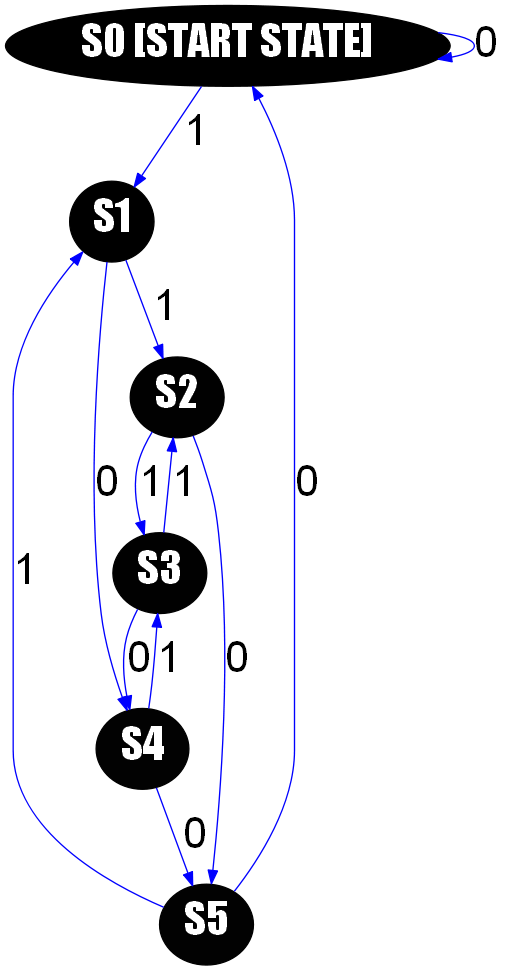

S0 13401
S1 13363
S2 13335
S3 13332
S5 13274
S4 13295


In [ ]:
#Train the agent
# You are probably using a MlpPolicy instead of a MultiInputPolicy (cf doc)
# AttributeError: 'dict' object has no attribute 'flatten'
model = A2C('MultiInputPolicy', env, gamma=0.99, verbose=0).learn(100000)

In [127]:
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
# Instantiate the env
env = FSMEnv('toaster.csv', start_state_id=0)
# wrap it
# my_env = FSMRenderingWrapper(env)
env = make_vec_env(lambda: env, n_envs=1, monitor_dir="./")
# wrap it again

INFO: The CSV file provided already contains discretized state names.
Discrete(3)
Dict(amount_of_states:Discrete(10), current_state:Discrete(9), past_states:Box(0, 9223372036854775807, (9,), int64), transitions_to_states:Box(0, 9223372036854775807, (9,), int64))
Box(0, 9223372036854775807, (9,), int64)
Amount of rows: 8


In [ ]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output

graph = pydot.Dot(graph_type='digraph', strict=True)

graph.add_node(pydot.Node(name=1, style="filled", fillcolor="0.0 0.0 0.5", fontcolor="black"))
graph.add_node(pydot.Node(name=2, style="filled", fillcolor="0.0 0.0 0.0"))
graph.add_edge(pydot.Edge(1, 3))
graph.add_edge(pydot.Edge(1, 4))
graph.add_edge(pydot.Edge(2, 4))

for node in graph.get_nodes():
    print(node.get_label())

for edge in graph.get_edges():
    print(type(edge.get_source()), type(edge.get_destination()))

plt = Image(graph.create_png())
display(plt)

In [ ]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output

graph = pydot.Dot(graph_type='digraph', strict=True)
graph.add_edge(pydot.Edge("1", "2"))
graph.add_edge(pydot.Edge("3", "2"))
plt = Image(graph.create_png())
display(plt)

In [ ]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output

graph = pydot.Dot(graph_type='digraph', strict=True)
for i in range(2, 100):
    graph.add_edge(pydot.Edge("1", "{}".format(i)))
    graph.add_edge(pydot.Edge("{}".format(i-1), "{}".format(i)))
    if i % 50 == 0:
        print("Aaa")
        # plt = Image(graph.create_png())
        # display(plt)
        # clear_output(wait=True)
graph.write_png("Aaa.png")

In [ ]:
import gym

from stable_baselines3 import PPO

env = gym.make('CartPole-v0')

model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()

In [ ]:
env = GoLeftEnv(grid_size=10)

obs = env.reset()
env.render()

print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())

GO_LEFT = 0
# Hardcoded best agent: always go left!
n_steps = 20
for step in range(n_steps):
  print("Step {}".format(step + 1))
  obs, reward, done, info = env.step(GO_LEFT)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render()
  if done:
    print("Goal reached!", "reward=", reward)
    break

In [ ]:
# Test the trained agent
obs = env.reset()
n_steps = 20
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render(mode='console')
  if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print("Goal reached!", "reward=", reward)
    break

In [ ]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output

# Render here
class FSMRenderingEnvWrapper(gym.Wrapper):
  """
  :param env: (gym.Env) Gym environment that will be wrapped
  """
  def __init__(self, env: gym.Env):

    # Initialize the graph here
    self.rendering_graph = pydot.Dot(graph_type='digraph', strict=True)
    self.rendering_heatmap_dict = {}
    self.num_timesteps = 0
    self.total_amount_of_visits = 0
    
    # Add a node and edge during step function

    # Store the amount of visits to a node
    # When drawing, convert that to RGB:
    
    # Node A: 30 visits
    # Node B: 1 visit

    # Node A: 255, 255, 255
    # Node B: 1, 1, 1

    # Call the parent constructor, so we can access self.env later
    super(FSMRenderingWrapper, self).__init__(env)
  
  def reset(self):
    """
    Reset the environment 
    """
    obs = self.env.reset()

    # Add the initial node
    if self.env.current_unique_id_state not in self.rendering_heatmap_dict:
      self.rendering_heatmap_dict[self.env.current_unique_id_state] = 1

      with open(self.env.file_name, 'r') as csv_file:
        # pass the file object to DictReader() to get the DictReader object
        csv_dict_reader = DictReader(csv_file)

        # iterate over each line as a ordered dictionary
        for row in csv_dict_reader:
          # row variable is a dictionary that represents a row in csv
          if int(row['Unique_ID']) == self.env.current_unique_id_state:
            # print("Unique ID in row:", row['Unique_ID'], "Self.env.current_unique_id_state:", self.env.current_unique_id_state)
            original_name = row['State_name']
            
      start_state_name = original_name + " " + "[START STATE]"

      self.rendering_graph.add_node(pydot.Node(name=self.env.current_unique_id_state, label=start_state_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))

    # else:
    #   self.rendering_heatmap_dict[self.env.current_unique_id_state] += 1
    #   self.total_amount_of_visits += 1
      
    return obs

  def step(self, action):
    """
    :param action: ([float] or int) Action taken by the agent
    :return: (np.ndarray, float, bool, dict) observation, reward, is the episode over?, additional informations
    """
    # Store temporarily current unique id to draw edge
    previous_node = self.env.current_unique_id_state

    obs, reward, done, info = self.env.step(action)

    new_node_found = False

    # STORE AMOUNT OF VISITS AT ALL TIMES
    # Just create a new node if not in the heatmap dict yet and is not start state id
    # wait, no
    # actually yes, fuk it - make it a black void

    # if self.env.current_unique_id_state != self.env.start_state_id:
    if self.env.current_unique_id_state not in self.rendering_heatmap_dict:
      self.rendering_heatmap_dict[self.env.current_unique_id_state] = 1
      new_node_found = True
    
    else:
      self.rendering_heatmap_dict[self.env.current_unique_id_state] += 1
      self.total_amount_of_visits += 1

    with open(self.env.file_name, 'r') as csv_file:
      # pass the file object to DictReader() to get the DictReader object
      csv_dict_reader = DictReader(csv_file)

      # iterate over each line as a ordered dictionary
      for row in csv_dict_reader:
        if int(row['Unique_ID']) == previous_node:
          transition_name = row['Transition_names'].split()[action]
          
        if new_node_found == True:
        # row variable is a dictionary that represents a row in csv
          if int(row['Unique_ID']) == self.env.current_unique_id_state:
            # print("Unique ID in row:", row['Unique_ID'], "Self.env.current_unique_id_state:", self.env.current_unique_id_state)
            original_name = row['State_name']
    
    if new_node_found == True:
      if self.env.randomize_start_state == True:
        if self.env.current_unique_id_state in self.env.start_states:
          start_state_name = original_name + " " + "[START STATE]"
          self.rendering_graph.add_node(pydot.Node(name=self.env.current_unique_id_state, label=start_state_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))
        else:
          self.rendering_graph.add_node(pydot.Node(name=self.env.current_unique_id_state, label=original_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))
      else:
        self.rendering_graph.add_node(pydot.Node(name=self.env.current_unique_id_state, label=original_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))
    
    current_node = self.env.current_unique_id_state 
    # Add edge between previous and current node
    self.rendering_graph.add_edge(pydot.Edge(previous_node, current_node, label=transition_name, color='black', fontname="Arial", fontsize='32'))
    
    self.num_timesteps += 1

    if self.num_timesteps % 5000 == 0:
      local_max = 0
      for node in self.rendering_graph.get_nodes():
        if self.rendering_heatmap_dict[int(node.get_name())] > local_max:
          local_max = self.rendering_heatmap_dict[int(node.get_name())]
          
      for node in self.rendering_graph.get_nodes():
        amount_of_visits = self.rendering_heatmap_dict[int(node.get_name())]
        # Convert the range from 0.0 - local_max to 1.0 - 0.0 for heatmap colouring
        # NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
        # Linear something
        new_hsv_value = (-amount_of_visits / local_max) + 1.0
        node.set_fillcolor("0.0 0.0 {}".format(new_hsv_value))
        if new_hsv_value <= 0.5:
          node.set_fontcolor("white")

        # with open(self.env.file_name, 'r') as csv_file:
        #   # pass the file object to DictReader() to get the DictReader object
        #   csv_dict_reader = DictReader(csv_file)

        #   # iterate over each line as a ordered dictionary
        #   for row in csv_dict_reader:
        #     # row variable is a dictionary that represents a row in csv
        #     if row['Unique_ID'] == node.get_name():
        #       print("Unique ID in row:", row['Unique_ID'], "Self.env.current_unique_id_state:", self.env.current_unique_id_state)
        #       node.set_label(row['State_name'] + " " + str(self.rendering_heatmap_dict[int(node.get_name())]) + "/" + str(self.total_amount_of_visits))
              
        # node.set_label(self.rendering_heatmap_dict[int(node.get_name())])
            
      clear_output(wait=True)
      plt = Image(self.rendering_graph.create_png())
      display(plt)
      for k, v in self.rendering_heatmap_dict.items():
        with open(self.env.file_name, 'r') as csv_file:
          # pass the file object to DictReader() to get the DictReader object
          csv_dict_reader = DictReader(csv_file)

          # iterate over each line as a ordered dictionary
          for row in csv_dict_reader:
            if int(row['Unique_ID']) == k:
              # print("Unique ID in row:", row['Unique_ID'], "Self.env.current_unique_id_state:", self.env.current_unique_id_state)
              original_name = row['State_name']
        print(original_name, v)

    return obs, reward, done, info


In [ ]:
a = [1, 2]
b = [3, 4]
c = [5, 6]

for x, y, z in zip(a, b, c):
    print(x, y, z)

1 3 5
2 4 6


In [ ]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

# Instantiate the env
env = FSMEnv('pelican.csv', start_state_id=1)
# wrap it
env = make_vec_env(lambda: env, n_envs=1)
env = FSMRenderingWrapper(env)
# wrap it again

INFO: The CSV file provided already contains discretized state names.
Discrete(2)
Dict(amount_of_states:Discrete(8), current_state:Discrete(7), past_states:Box(0, 9223372036854775807, (7,), int64), transitions_to_states:Box(0, 9223372036854775807, (7,), int64))
Box(0, 9223372036854775807, (7,), int64)
Amount of rows: 6
ERROR: This wrapper only works with SubprocVecEnvs due to
the impossibility of running several agents on the same environment.
When using the make_vec_env helper function to create a vectorized environment from FSMEnv,
please set the vec_env_cls parameter to SubprocVecEnv (vec_env_cls=SubprocVecEnv).


FSMWrapperError: 

In [ ]:
# NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
# if value < 0.5 white text
# if value > 0.5 black text
# set HSV filled color for nodes when rendering

NewValue = (400 * - 1.0) / (500) + 1.0
NewValue

0.19999999999999996